# mRNA renal cell carcinoma prediction
Note: cleaned data from preprocessing script must be input here.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt
from cox_functions import categorize_expression_levels, cox_ph_pipeline, normalize_gene_expression
from copy import deepcopy

from numpy.random import seed
seed(1)

import scipy
print('scipy version: ', scipy.__version__)


# !pip install lifelines

from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# from XGBoostPipeline import XGBoostPipeline
from XGBoostPipelineLatest import XGBoostPipeline
from sklearn.metrics import classification_report

scipy version:  1.5.4


In [3]:
def load_data(filename):
#     df = pd.read_csv('../data/KIRC_TCGA_microRNA_expression_and_clinical.csv')
    df = pd.read_csv(filename)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    # DO NOT SET THE INDEX.  
    # You will run into an issue where every CoxPH model will return a 
    # concordance of 0.5 no matter what subset of features you use if you set the index.

    # Dropping columns that are not the target or related to microRNA expression

    label = "AJCC_PATHOLOGIC_TUMOR_STAGE"

    cols_to_drop = [
        'PATIENT_ID',
        "SEX_male_female",
        "RACE", 
        "ETHNICITY",
        "DFS_STATUS",
        "DFS_MONTHS",
    ]

    df.drop(columns=[ci for ci in cols_to_drop if ci in df.columns], inplace=True)

    # From dataset joining, the NaN values for tumor stage have been verified to be normal patients
    df[label].fillna('normal',inplace=True)
#     dfph=dfph.drop(index=np.where(dfph["OS_MONTHS"]==0)[0])
    # Map tumor stage categories to numeric categories
    tumor_stage_map = {
        "normal" : 0,
        "STAGE I" : 1,
        "STAGE II" : 1,
        "STAGE III" : 2,
        "STAGE IV" : 2
    }

    df[label] = df[label].map(tumor_stage_map)
    
    
    train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df["AJCC_PATHOLOGIC_TUMOR_STAGE"].values)

    train, val = train_test_split(train, test_size=0.2, random_state=32, stratify=train["AJCC_PATHOLOGIC_TUMOR_STAGE"].values)
    
    dfph = deepcopy(train)
    dfphtest = deepcopy(test)
    dfphval = deepcopy(val)
    
    dfph.loc[dfph['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfph.loc[dfph['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()
    
    dfphval.loc[dfphval['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfphval.loc[dfphval['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()

    dfphtest.loc[dfphtest['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_STATUS"]="0:LIVING"
    dfphtest.loc[dfphtest['AJCC_PATHOLOGIC_TUMOR_STAGE']==0,"OS_MONTHS"] = dfph['OS_MONTHS'].median()

    dfph['OS_STATUS'] = dfph['OS_STATUS'].astype('category').cat.codes
    dfphval['OS_STATUS'] = dfphval['OS_STATUS'].astype('category').cat.codes
    dfphtest['OS_STATUS'] = dfphtest['OS_STATUS'].astype('category').cat.codes
    
    if 'hsa-mir-4296' in dfph.columns:
        dfph.drop(columns=['hsa-mir-4296'], inplace=True)
        dfphval.drop(columns=['hsa-mir-4296'], inplace=True)
        dfphtest.drop(columns=['hsa-mir-4296'], inplace=True)
    
    empty_features = []
    for col in dfph.columns:
        if (dfph[col].sum() == 0):
            empty_features.append(col)
    
    dfph.drop(columns=empty_features,inplace=True)
    dfphval.drop(columns=empty_features,inplace=True)
    dfphtest.drop(columns=empty_features,inplace=True)

    gc = list(dfph.columns)
    genes = gc[3:]

#     return train, val, test, gc
    return dfph, dfphval, dfphtest, genes, label


In [4]:
# def normalize_expression(dfph, dfphval, dfphtest, genes):
    
#     dfph = normalize_gene_expression(dfph, genes);   
#     dfphval = normalize_gene_expression(dfphval, genes);
#     dfphtest = normalize_gene_expression(dfphtest, genes)

In [5]:
def run_cox(dfph, dfphval, dfphtest, genes, pvalue=.05, dataset_name="final_microRNA_plus_normal_trainvaltest"):
    
    dfph = normalize_gene_expression(dfph, genes);   
    dfphval = normalize_gene_expression(dfphval, genes);
    dfphtest = normalize_gene_expression(dfphtest, genes)
    
    dfph = categorize_expression_levels(dfph, genes)
    dfphval = categorize_expression_levels(dfphval, genes)    
    dfphtest = categorize_expression_levels(dfphtest, genes)
    
    print('Running Cox PH on train set\n')
    info_map, significant_genes = cox_ph_pipeline(
                dfph, 
                genes, 
                dataset_name=dataset_name, 
                duration="OS_MONTHS", 
                event="OS_STATUS",
                pvalue=pvalue
    )
    print('number of significant genes: ',len(significant_genes))
    return dfph, dfphval, dfphtest, info_map, significant_genes

In [6]:
def data_format_xgbpipeline(significant_genes, label = "AJCC_PATHOLOGIC_TUMOR_STAGE"):
    input_df = deepcopy(dfph[[label] + significant_genes])
    input_df_val = deepcopy(dfphval[[label] + significant_genes])
    input_df_test = deepcopy(dfphtest[[label] + significant_genes])

    all_columns = input_df.columns # Creates list of all column headers
    input_df[all_columns[1:]] = input_df[all_columns[1:]].astype('float')
    input_df_val[all_columns[1:]] = input_df_val[all_columns[1:]].astype('float')
    input_df_test[all_columns[1:]] = input_df_test[all_columns[1:]].astype('float')
    
    return input_df, input_df_val, input_df_test

In [7]:
def evaluate_xgbpipeline(input_df_test, pipeline):
    xgb_model = XGBClassifier()
    xgb_model.load_model(pipeline.model_filepath)
    hr_pred = xgb_model.predict(input_df_test[input_df_test.columns[1:]])
    hr_pred_proba = xgb_model.predict_proba(input_df_test[input_df_test.columns[1:]])#,validate_features=True)#, input_df_test[input_df.columns[0]].values-1)
    hr_pred_proba_norm = hr_pred_proba[:,np.shape(hr_pred_proba)[1]//2:].T
    roc_auc_score_ovo = roc_auc_score(
                input_df_test[input_df_test.columns[0]].values,
                hr_pred_proba_norm,
                multi_class='ovo'
            )

    roc_auc_score_ovr = roc_auc_score(
                input_df_test[input_df_test.columns[0]].values,
                hr_pred_proba_norm,
                multi_class='ovr'
            )
    print(classification_report(hr_pred, input_df_test[input_df_test.columns[0]]))
    print('roc_auc_ovo: ', roc_auc_score_ovo, 'roc_auc_ovr: ',roc_auc_score_ovr)
    return roc_auc_score_ovo, roc_auc_score_ovr


In [8]:


def save_importance_matrix(model, dataset_name='final_microRNA_james'):

    print("Creating importance matrix")

    feature_importance_dict = {}
    importance_types = ['gain', 'cover', 'weight', 'total_gain', 'total_cover']

    for metric in importance_types:
        feature_importance_dict[metric] = model.get_booster().get_score(importance_type=metric)

    importance_matrix = pd.DataFrame(feature_importance_dict)
    importance_matrix_filepath = "../final_results/XGBoost/{}_xgboost_feature_importance_latest.csv".format(dataset_name)

#         print("Saving importance matrix to:", importance_matrix_filepath)
#         importance_matrix.to_csv(importance_matrix_filepath)

    return importance_matrix

# Run

In [9]:
filename = "../data/KIRC_TCGA_GTEX_mRNA_expression_and_clinical_normalized.csv"
dfph, dfphval, dfphtest, genes, label = load_data(filename)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,2,3,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
# cph_map = {} #k: gene_name, v: {info about model}
filepath = '../final_results/final_mRNA_plus_normal_trainvaltest_individual_cox_results.json'
f = open(filepath, "r")
cph_map = json.load(f)
f.close()

all_genes_df = pd.DataFrame(cph_map).T

# significant_genes_05 = significant_genes.copy()

significant_genes = all_genes_df.loc[all_genes_df.sort_values('p-value')['p-value'].values<.05].index.values

significant_genes = [si for si in significant_genes]

len([si for si in significant_genes])

5569

In [11]:

input_df, input_df_val, input_df_test = data_format_xgbpipeline(significant_genes)

In [19]:

pipeline = XGBoostPipeline(
    pd.concat([input_df,input_df_val]),
    random_state=60, 
    label_column=label,
    num_classes=3, 
    weighted=False,
    n_iter=50,
    model_name="final_mRNA_multiclass_post_cox_bayes_opt_xgboost_best_james_ttv2.json",
    json_filepath="final_mRNA_multiclass_post_cox_bayes_opt_xgboost_best_output_james_ttv2.json",
    dataset_name="final_mRNA",
#     X_train=input_df[input_df.columns[1:]],
#     y_train=input_df[input_df.columns[0]],
#     X_test=input_df_val[input_df.columns[1:]],
#     y_test=input_df_val[input_df.columns[0]]
)

pipeline.run_workflow()

Initializing pipeline:
Initializing test and train data:
Running XGBoost pipeline
Beginning Bayesian Optimization:

|   iter    |  target   |    eta    |   gamma   | max_de... | max_depth |
-------------------------------------------------------------------------
|  1        |  0.8453   |  0.3079   |  0.1869   |  8.756    |  7.66     |
|  2        |  0.8408   |  0.5713   |  0.3983   |  10.11    |  3.074    |
|  3        |  0.8454   |  0.1787   |  0.1234   |  17.62    |  9.121    |
|  4        |  0.8458   |  0.277    |  0.1405   |  17.65    |  9.128    |
|  5        |  0.8487   |  0.7922   |  0.2426   |  17.85    |  9.166    |
Best AUC: 0.848742724867725
Best parameters: {'eta': 0.7922203053182407, 'gamma': 0.24264067575499107, 'max_delta_step': 17.853711554895643, 'max_depth': 9.166231294401388}
{'eta': 0.7922203053182407, 'gamma': 0.24264067575499107, 'max_delta_step': 17.853711554895643, 'max_depth': 9, 'eval_metric': 'auc', 'objective': 'multi:softprob', 'num_class': 3, 'min_child_w

# Final fit

In [1]:
input_df_final = pd.concat([input_df,input_df_val])

xgb_model_final = XGBClassifier(pipeline.best_params,objective='multi:softprob')

xgb_model_final.fit(X=input_df_final[input_df_final.columns[1:]],y=input_df_final[input_df_final.columns[0]])#,eval_metric='multi:softprob')


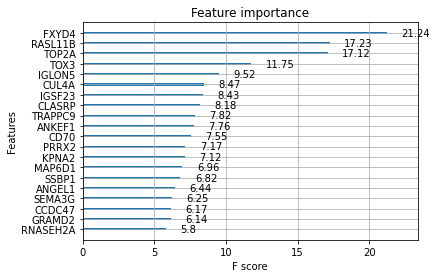

In [21]:

from xgboost import plot_importance

# Get the booster from the xgbmodel
booster = xgb_model_final.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],2)

# provide the importance dictionary to the plotting function
ax = plot_importance(importance, max_num_features=20, importance_type='gain', show_values=True)


# Autogluon

In [11]:
import pandas as pd
from autogluon.tabular import TabularPredictor as task
from sklearn.model_selection import train_test_split
import json

In [12]:
input_df_final = pd.concat([input_df,input_df_val])

In [13]:
time_limit = 180*1
metric = 'roc_auc_ovo_macro' 
save_path = '../final_results/AutoGluon/models/mRNA'  # specifies folder to store trained models
predictor = task(
    label=label, 
    path=save_path, 
    eval_metric=metric).fit(input_df_final, time_limit=time_limit)#,                           
#         hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,)#, presets='best_quality')

Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "../final_results/AutoGluon/models/mRNA/"
AutoGluon Version:  0.3.1
Train Data Rows:    405
Train Data Columns: 5569
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    126346.32 MB
	Train Data (Original)  Memory Usage: 18.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTyp

[20:12:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.8291	 = Validation score   (roc_auc_ovo_macro)
	46.16s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetMXNet ... Training model for up to 26.72s of the 26.54s of remaining time.
	0.8911	 = Validation score   (roc_auc_ovo_macro)
	13.25s	 = Training   runtime
	2.69s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 10.56s of the 10.38s of remaining time.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[21]	train_set's multi_logloss: 0.390576	train_set's roc_auc_ovo_macro: 1	valid_set's multi_logloss: 0.809444	valid_set's roc_auc_ovo_macro: 0.80

In [15]:
predictor.evaluate(input_df_test)

Evaluation: roc_auc_ovo_macro on test data: 0.8759131103421761
Evaluations on test data:
{
    "roc_auc_ovo_macro": 0.8759131103421761,
    "accuracy": 0.735632183908046,
    "balanced_accuracy": 0.7572755417956657,
    "mcc": 0.6009272578354864
}


{'roc_auc_ovo_macro': 0.8759131103421761,
 'accuracy': 0.735632183908046,
 'balanced_accuracy': 0.7572755417956657,
 'mcc': 0.6009272578354864}

In [45]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.896249,2.724961,26.194055,0.003094,3.394044,2,True,13
1,NeuralNetMXNet,0.891115,2.692266,13.250540,2.692266,13.250540,1,True,11
2,CatBoost,0.856244,0.079102,55.515267,0.079102,55.515267,1,True,7
3,LightGBMXT,0.852060,0.029601,9.549471,0.029601,9.549471,1,True,3
4,LightGBM,0.847163,0.028573,10.635069,0.028573,10.635069,1,True,4
5,RandomForestEntr,0.844047,0.108880,3.789447,0.108880,3.789447,1,True,6
6,ExtraTreesEntr,0.835574,0.108996,3.537303,0.108996,3.537303,1,True,9
7,RandomForestGini,0.831093,0.109040,3.459631,0.109040,3.459631,1,True,5
8,XGBoost,0.829060,0.039434,46.158945,0.039434,46.158945,1,True,10
9,ExtraTreesGini,0.818020,0.108950,3.449311,0.108950,3.449311,1,True,8


In [ ]:
%%time
## Feature importance by autogluon

ag_feature_importance_test = predictor.feature_importance(input_df_test)
ag_feature_importance_test.head()

Computing feature importance via permutation shuffling for 5569 features using 174 rows with 3 shuffle sets...
	50177.81s	= Expected runtime (16725.94s per shuffle set)


In [42]:
ag_feature_importance_test.head()

,importance,stddev,p_value,n,p99_high,p99_low
GNG7,0.002113,0.000841,0.024476,3,0.006931,-0.002705
BCR,0.002016,0.001607,0.080939,3,0.011225,-0.007192
B3GALT1,0.001641,0.000733,0.030286,3,0.005842,-0.002560
SPTSSB,0.001590,0.000669,0.027155,3,0.005426,-0.002246
GLS2,0.001577,0.000893,0.046195,3,0.006695,-0.003541


In [ ]:
%%time
## Feature importance by autogluon

ag_feature_importance = predictor.feature_importance(input_df_final)
ag_feature_importance.head()

Computing feature importance via permutation shuffling for 5569 features using 405 rows with 3 shuffle sets...
	55531.05s	= Expected runtime (18510.35s per shuffle set)


In [18]:
ag_feature_importance.head()

,importance,stddev,p_value,n,p99_high,p99_low
TMCO2,0.001268,0.000169,0.002920,3,0.002234,0.000302
NKX2-3,0.000731,0.000261,0.020054,3,0.002229,-0.000767
SNAP91,0.000665,0.000097,0.003536,3,0.001224,0.000107
CYP1A2,0.000642,0.000243,0.022298,3,0.002036,-0.000751
CTAG1A,0.000542,0.000219,0.025103,3,0.001795,-0.000711


In [2]:
# ag_feature_importance.to_csv('/home/ec2-user/SageMaker/daniel/mRNA_train_james.csv')

# ag_feature_importance.to_csv('/home/ec2-user/SageMaker/daniel/final_results/AutoGluon/models/mRNA/mRNA_james.csv')

In [25]:
ag_feature_importance.sort_values("importance")[::-1][:40]

,importance,stddev,p_value,n,p99_high,p99_low
TMCO2,0.001268,0.000169,0.002920,3,0.002234,0.000302
NKX2-3,0.000731,0.000261,0.020054,3,0.002229,-0.000767
SNAP91,0.000665,0.000097,0.003536,3,0.001224,0.000107
CYP1A2,0.000642,0.000243,0.022298,3,0.002036,-0.000751
CTAG1A,0.000542,0.000219,0.025103,3,0.001795,-0.000711
LHFPL5,0.000512,0.000438,0.090087,3,0.003020,-0.001996
RNASE13,0.000505,0.000180,0.019996,3,0.001539,-0.000529
WIF1,0.000505,0.000452,0.096271,3,0.003095,-0.002085
SPACA5B,0.000500,0.000113,0.008351,3,0.001149,-0.000149
RXFP4,0.000494,0.000058,0.002314,3,0.000829,0.000159
